# Лабораторная работа №3

## Бесконечномерные экстремальные задачи

Найти оптимальную функцию $u(x)∈L_2(S)$, доставляющую минимум *явно* заданному квадратичному  функционалу $J(u)$, с точностью $\epsilon = 10^{-10}$ методом с регулируемым направлением спуска (МРНСг) [монография Толстых В.К. Практическая оптимизация, идентификация распределённых систем](https://tolstykh.com/docs/Публикации/Практическая%20оптимизация,%20идентификация%20распределённых%20систем.pdf) на основе градиента $∇J(u;x)∈L_2(S)$. 

## Импорт необходимых библиотек

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output

Определим ряд полезных функций

Критерии остановки по значению градиента (для внешних итераций) и по разнице между приближениями (для метода золотого сечения)

In [3]:
def must_stop_via_gradient(grad_u, epsilon=1e-10):
    return np.linalg.norm(grad_u) <= epsilon

def must_stop_via_difference(u1, u2, epsilon=1e-15):
    return np.linalg.norm(u1 - u2) <= epsilon

Поиск наилучшего приближения методом золотого сечения

In [4]:
def find_best_approximation(u: np.array, x: np.array, j_function, grad: np.array, step: int, epsilon=1e-14, alpha=1):
    tau = (np.sqrt(5) - 1) / 2
    iterations = 0
    u_a = u.copy()
    u_b = u_a - step / np.linalg.norm(grad * alpha) * grad * alpha
    while True:
        u1 = u_b - tau * (u_b - u_a)
        u2 = u_a + tau * (u_b - u_a)
        j_u1 = j_function(u1, x)
        j_u2 = j_function(u2, x)
        if j_u1 < j_u2:
            u_b = u2
            continue
        u_a = u1
        iterations += 1
        if must_stop_via_difference(u_a, u_b, epsilon):
            return (u_a + u_b) / 2, iterations

Реализация метода градиентного спуска с регулируемым направлением

In [5]:
def regulated_gradient_descent(u_start: np.array, x: np.array, j_function, epsilon=1e-6, step=100, alpha=1):
    current_u = u_start
    history = [(u_start, j_function(u_start, x))]
    iterations = 0
    internal_iterations = 0

    while True:
        grad = gradient(current_u)

        new_u, step_iterations = find_best_approximation(u=current_u, x=x,
                                                         j_function=j_function,
                                                         grad=grad,
                                                         step=step,
                                                         alpha=alpha)
        internal_iterations += step_iterations
        iterations += 1

        history.append((new_u, j_function(new_u, x)))

        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.plot(new_u, label=f"Итерация {iterations}")
        plt.title(f"Норма градиента составляет: {np.linalg.norm(grad)}")
        plt.legend()
        plt.grid()
        plt.show()

        if must_stop_via_gradient(grad, epsilon):
            break

        current_u = new_u

    plt.ioff()
    plt.show()

    return history, iterations, internal_iterations

### Определение оптимизируемого функционала

Определим интересующую нас точность

In [6]:
EPSILON = 1e-10

Зададим диапазон изменения $x$, им будет отрезок от `0` до `1` и начальное приближение - квадратный корень из 100 линейно распределенных значений от `0.2` до `1`, то есть на практике мы будем минимизировать 100-мерный функционал

In [7]:
x_vals = np.linspace(0, 1, 100)
u_vals = np.sqrt(np.linspace(0.2, 1, 100))

Построим график начального приближения

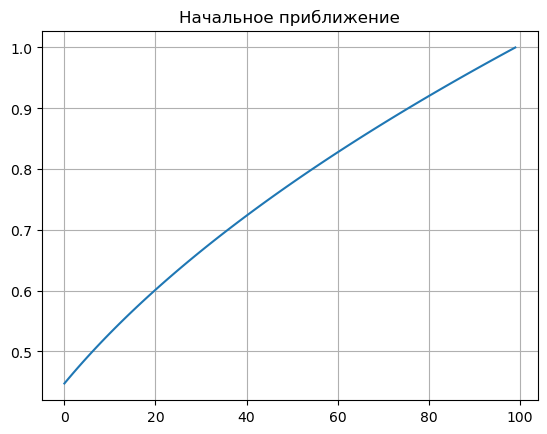

In [8]:
plt.plot(u_vals)
plt.title("Начальное приближение")
plt.grid()
plt.show()

Мы видим что начальное приближение нелинейно, а значит в данном случае будет иметь место использование параметра $\alpha(x)$, отвечающего за регулировку направления градиентного спуска

В качестве оптимизируемого функционала возьмем следующий:

\begin{equation}
J(u) = \int_0^1u^2 + 10(x - 1) ^ 2 dx
\end{equation}

Численное интегрирование будем проводить методом трапеций. Создадим соответствующую функцию

In [9]:
def J(u, x):
    integrand = u**2 + 10 * (x - 1) ** 2
    return np.trapz(integrand, x)

Вычислим значение функционала в начальном приближении

In [10]:
current_j = J(u_vals, x_vals)
current_j

3.9335033840084352

### Проверка функционала на квадратичность

Для проверки функционала на квадратичность возьмем 100 точек управления $u$ на отрезке [-1, 1] и посмотрим на график значений функционала. Если функционал действительно квадратичный - мы получим выпуклую параболу $J(u)$

In [11]:
u_test = np.linspace(-1, 1, 100)
j_test = [J(np.full_like(x_vals, fill_value=u), x_vals) for u in u_test]

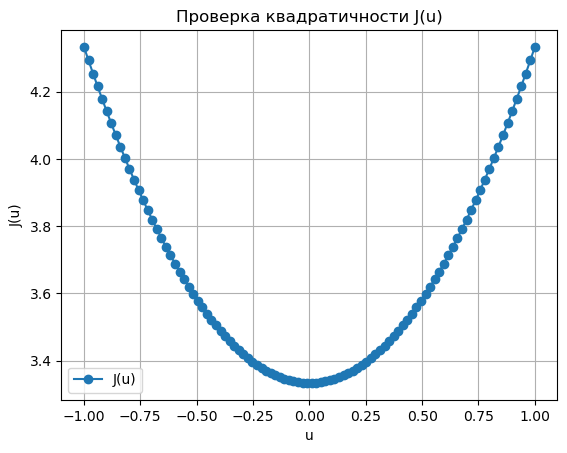

In [12]:
plt.plot(u_test, j_test, 'o-', label='J(u)')
plt.xlabel("u")
plt.ylabel("J(u)")
plt.title("Проверка квадратичности J(u)")
plt.legend()
plt.grid()
plt.show()

На графике видна выпуклая парабола, это означает что выбранный нами функционал действительно является квадратичным

### Определение градиента целевого функционала

Если целевой функционал описывается формулой:

\begin{equation}
J(u) = \int_0^1u^2 + 10(x - 1) ^ 2 dx
\end{equation}

то его градиент будет производной $J(u)$ по $u(x)$ в каждой точке. Для данного функционала он будет равен:

\begin{equation}
\nabla J = \frac{\delta J}{\delta u(x)} = 2u(x) = 2u
\end{equation}

Напишем функцию, вычисляющую градиент целевого функционала

Аналитически можно заметить, что минимум функционала достигается при значении управления $u(x) = 0$. Это подтверждает и график, построенный для проверки функционала на квадратичность. Используем это наблюдение для проверки результатов, полученных численными методами

In [13]:
def gradient(u):
    return 2 * u

### Минимизация функционала с помощью бесконечномерного градиентного метода наискорейшего спуска

Суть метода заключается в следующем:

пусть у нас есть начальное приближение $u^k(x)$ - функция, зависящая от $x$, тогда мы можем вычислить следующее приближение $u^{k+1}(x)$ по формуле:

\begin{equation}
u^{k+1}(x) = u^k(x) - b^k\nabla J(u^k; x)
\end{equation}

где

$x ∈ S$, $k = 0,1...$


\begin{equation}
b^k = arg \min_{b>0} J(u^k - b\nabla J^k)
\end{equation}

минимизация одномерной функции $J(b)$

В качестве необходимого условия оптимальности будем использовать:

\begin{equation}
||\nabla J(u_*)||_{L_2(S)} \le \epsilon
\end{equation}

Выполним сам поиск экстремума

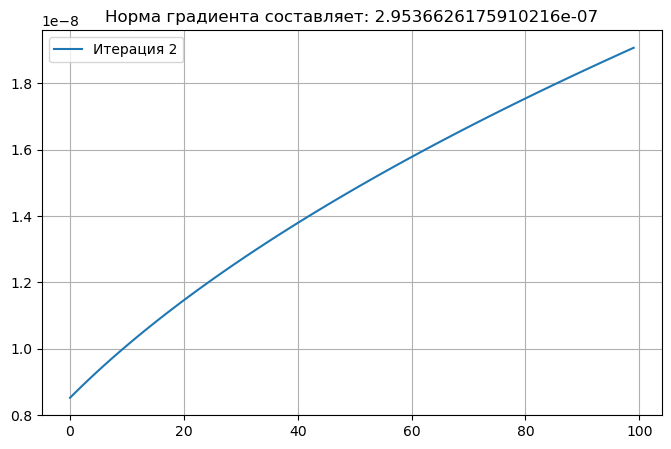

In [14]:
non_alpha_trajectory, steps, internal_steps = regulated_gradient_descent(u_start=u_vals, x=x_vals, j_function=J, step=100)

Можно заметить, что форма найденной функции совпадает с начальным приближением, изменился только масштаб, показывающий близость функции к 0

In [15]:
print(f"Минимум функционала был найден за общее число итераций: {steps + internal_steps}")
print(f"Из них внешних итераций: {steps}")
print(f"Внутренних: {internal_steps}")

Минимум функционала был найден за общее число итераций: 69
Из них внешних итераций: 2
Внутренних: 67


Посмотрим на найденный функционал

In [16]:
non_alpha_extremum = non_alpha_trajectory[-1]
non_alpha_extremum

(array([8.52648954e-09, 8.69703619e-09, 8.86430223e-09, 9.02846997e-09,
        9.18970529e-09, 9.34816026e-09, 9.50397354e-09, 9.65727333e-09,
        9.80817753e-09, 9.95679459e-09, 1.01032260e-08, 1.02475651e-08,
        1.03898993e-08, 1.05303096e-08, 1.06688722e-08, 1.08056583e-08,
        1.09407342e-08, 1.10741627e-08, 1.12060028e-08, 1.13363094e-08,
        1.14651353e-08, 1.15925297e-08, 1.17185393e-08, 1.18432078e-08,
        1.19665778e-08, 1.20886890e-08, 1.22095788e-08, 1.23292836e-08,
        1.24478370e-08, 1.25652721e-08, 1.26816195e-08, 1.27969095e-08,
        1.29111699e-08, 1.30244279e-08, 1.31367095e-08, 1.32480395e-08,
        1.33584417e-08, 1.34679390e-08, 1.35765534e-08, 1.36843053e-08,
        1.37912154e-08, 1.38973036e-08, 1.40025876e-08, 1.41070859e-08,
        1.42108160e-08, 1.43137941e-08, 1.44160368e-08, 1.45175596e-08,
        1.46183771e-08, 1.47185041e-08, 1.48179546e-08, 1.49167422e-08,
        1.50148797e-08, 1.51123799e-08, 1.52092550e-08, 1.530551

In [17]:
print(f"Значение функционала при найденной функции u(x) составляет: {non_alpha_extremum[1]}")

Значение функционала при найденной функции u(x) составляет: 3.3335033840084343


Проверим, совпадает ли полученное значение функционала с аналитическим минимумом

In [18]:
assert non_alpha_extremum[1] - J(np.zeros(100), x_vals) <= EPSILON
print("Решение удовлетворяет заданной точности")

Решение удовлетворяет заданной точности


Построим на одном графике начальное приближение и найденную функцию

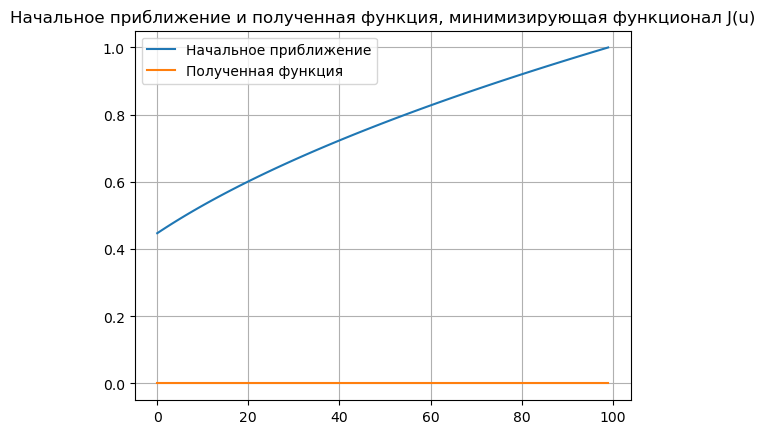

In [19]:
plt.plot(u_vals, label="Начальное приближение")
plt.plot(non_alpha_extremum[0], label="Полученная функция")
plt.title("Начальное приближение и полученная функция, минимизирующая функционал J(u)")
plt.grid()
plt.legend()
plt.show()

Как видно, на исходном масштабе полученная фунция практически вырождается в константу $u(x) = 0$, но фактически результат повторяет форму начального приближения

### Минимизация функционала с помощью метода с регулируемым направлением градиентного спуска

Суть метода заключается в следующем:

пусть у нас есть начальное приближение $u^k(x)$ - функция, зависящая от $x$, тогда мы можем вычислить следующее приближение $u^{k+1}(x)$ по формуле:

\begin{equation}
u^{k+1}(x) = u^k(x) - b^k\alpha(x)\nabla J(u^k; x)
\end{equation}

где $\alpha(x)$ - параметр, отвечающий за направление спуска

Одним из способов выбора $\alpha(x)$ является движение под 45°. Параметр вычисляется по формуле:

\begin{equation}
\alpha(x) = \Bigg|\frac{\delta}{\nabla J(u^0; x)}\Bigg|
\end{equation}

где $\delta$ - параметр, описывающий силу регуляции направления градиентного спуска (берется от `0` до `1`)

Зададим $\delta$ и вычислим $\alpha$ на основе градиента начального приближения

In [20]:
delta = 0.316
alpha = np.abs(delta / gradient(u_vals))
alpha

array([0.35329874, 0.34637064, 0.33983476, 0.33365543, 0.32780137,
       0.32224501, 0.31696195, 0.31193049, 0.30713127, 0.30254697,
       0.298162  , 0.29396232, 0.28993525, 0.28606927, 0.28235393,
       0.27877969, 0.27533783, 0.27202038, 0.26882003, 0.26573005,
       0.26274422, 0.25985683, 0.25706259, 0.2543566 , 0.25173429,
       0.24919146, 0.24672415, 0.24432872, 0.24200172, 0.23973998,
       0.23754048, 0.23540043, 0.2333172 , 0.23128832, 0.22931146,
       0.22738444, 0.22550519, 0.22367179, 0.22188239, 0.22013525,
       0.21842875, 0.21676133, 0.21513152, 0.21353794, 0.21197924,
       0.21045419, 0.20896159, 0.2075003 , 0.20606925, 0.2046674 ,
       0.20329378, 0.20194745, 0.20062752, 0.19933313, 0.19806348,
       0.19681779, 0.1955953 , 0.19439532, 0.19321716, 0.19206016,
       0.1909237 , 0.18980718, 0.18871001, 0.18763166, 0.18657159,
       0.18552928, 0.18450425, 0.18349602, 0.18250414, 0.18152818,
       0.18056771, 0.17962232, 0.17869163, 0.17777525, 0.17687

Выполним поиск экстремума методом с регулируемым направлением градиентного спуска

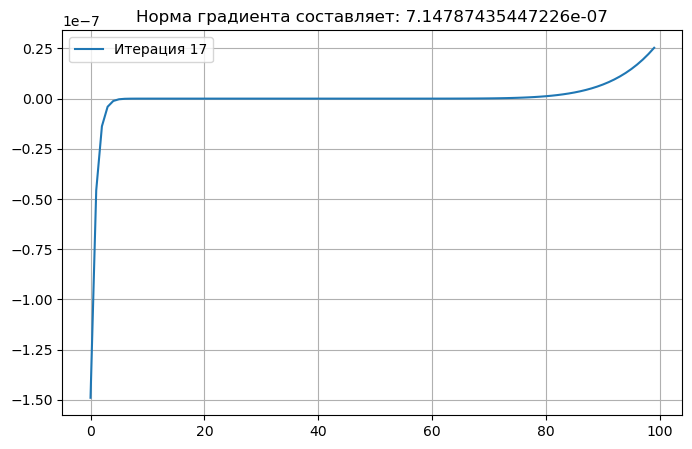

In [21]:
trajectory, steps, internal_steps = regulated_gradient_descent(u_start=u_vals, x=x_vals, j_function=J, epsilon=1e-6, step=100, 
                                                               alpha=alpha)

Полученная функция уже не совпадает с начальным приближением. Можно заметить что она почти полностью состоит из нулей за исключением "выброса" на первой компоненте и небольшой нелинейности на компонентах, начинающихся примерно с 70-й

In [22]:
print(f"Минимум функционала был найден за общее число итераций: {steps + internal_steps}")
print(f"Из них внешних итераций: {steps}")
print(f"Внутренних: {internal_steps}")

Минимум функционала был найден за общее число итераций: 585
Из них внешних итераций: 17
Внутренних: 568


Алгоритм выполнил намного больше вычислений чем градиентный спуск, без регулировки направления, однако графически полученный результат подходит для решения задачи лучше, особенно если мы заменим выброс средним значением по компонентам

In [23]:
alpha_extremum = trajectory[-1]
alpha_extremum

(array([-1.49011612e-07, -4.57330540e-08, -1.37703169e-08, -4.04784972e-09,
        -1.15526691e-09, -3.18117435e-10, -8.38976215e-11, -2.10065456e-11,
        -4.94001786e-12, -1.07643160e-12, -2.13543230e-13, -3.76643057e-14,
        -5.71219112e-15, -7.08602574e-16, -6.63093070e-17, -4.03820237e-18,
        -1.15226484e-19, -4.98489212e-22,  1.13464580e-25,  6.65253900e-24,
        -1.44838162e-24,  5.95497393e-23,  1.75498697e-22, -2.31640396e-23,
        -3.20119764e-22, -3.12111437e-22, -1.19448378e-22, -1.38889054e-23,
        -5.61234205e-26, -1.70109368e-26,  6.25835356e-25,  5.32844417e-24,
         7.78228959e-22,  1.02772037e-20,  6.46613553e-20,  2.62180973e-19,
         7.67829756e-19,  1.67584636e-18,  2.54690156e-18,  1.44098474e-18,
        -6.53483752e-18, -3.05940739e-17, -8.38985602e-17, -1.77982717e-16,
        -3.05807706e-16, -4.03543471e-16, -2.76320499e-16,  5.32813344e-16,
         2.95861887e-15,  8.75010766e-15,  2.09727491e-14,  4.47311803e-14,
         8.8

In [24]:
print(f"Значение функционала при найденной функции u(x) составляет: {alpha_extremum[1]}")

Значение функционала при найденной функции u(x) составляет: 3.3335033840084347


In [25]:
assert alpha_extremum[1] - J(np.zeros(100), x_vals) <= EPSILON
print("Решение удовлетворяет заданной точности")

Решение удовлетворяет заданной точности


Построим на одном графике начальное приближение и найденную функцию

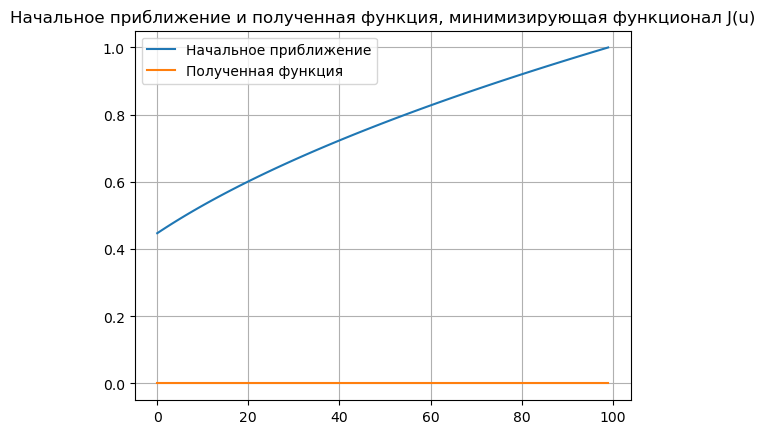

In [26]:
plt.plot(u_vals, label="Начальное приближение")
plt.plot(alpha_extremum[0], label="Полученная функция")
plt.title("Начальное приближение и полученная функция, минимизирующая функционал J(u)")
plt.grid()
plt.legend()
plt.show()

Как и в предыдущем случае, на исходном масштабе полученная фунция практически вырождается в константу $u(x) = 0$, но фактически результат **отличается** по форме от начального приближения, что делает его более подходящим с точки зрения интерпретации 